## Projeto 1

Este trabalho compara a eficiência e eficácia de múltiplos algoritmos de Aprendizado por Reforço (RL), sendo eles MonteCarlo, Sarsa(Lambda) e Q_learning, em diferentes cenários e variando seus parâmetros quando necessário. O ambiente/problema que foi usado como teste são labirintos, onde os algoritmos precisam encontrar uma politica ótima para que o agente consiga chegar até o final do labirinto.

### Ambiente
Como dito anteriormente, os ambientes são labirintos. Eles são descritos por meio de arquivos .txt, onde são apontados as paredes, caminhos, estados terminais, formato e suas recompensas. Os arquivos têm essa cara:
```
4 4
. path -1
@ agent -1
$ goal 100
# wall -1000
######
#...$#
#@...#
######
```

A primeira linha contém dois inteiros E e L, que representam o número de elementos e o número de linhas do labirinto. Aqui são descritos 4 elementos e será assado um labirinto de 4 linhas. Para os elementos tem-se que os caminhos são '.' e possuem recompensa de -1. Por sua vez, o estado terminal, ou objetivo, é representado por '$' e possui recompensa de 100. Por fim, após a descrição dos simbolos, há a descrição do próprio formato do labirinto.

Diferentes formatos de labirintos foram adotados para o trabalho, sendo alguns bem amplos, outros com diversos caminhos, e outros extremamente estreitos. As recompensas também foram alteradas para avaliar seu impacto, já que a escolha de uma função de recompensa boa também faz parte do processo de treinamento quando se trabalha com RL.

### Código
As primeiras células desse notebook contém o código usado para implementação e obtenção dos resultados. Porém para facilitar, foram geradas imagens com os resultados obtidos (usando pygame), e a análise foi feita em cima delas. O código está disponível para execução, alteração, e teste de outras configurações de labirinto.

### Métricas
Para comparação dos algoritmos entre si, foram extraídas as recompensas médias e o tamanho do caminho percorrido a partir de um mesmo ponto do mapa definidos na criação do mapa pelo valor 'agent', nesse caso '@'. Com isso é possível analisar o quão eficiente foi o caminho encontrado pelo algoritmo, caso encontrado, e se ele conseguiu convergir. Há também a analise de desempenho e custo computacional, o <b style="color:#770000">número médio de episódios para convergência</b>, o <b style="color:#770000">tempo de convergência</b>, os <b style="color:#770000">hiperparametros</b> necessários para ajustar o algoritmo, e o quão <b style="color:#770000">dificil</b> foi encontrar um valor ótimo.

Além disso, um mapa de calor gerado a partir da função valor será usado para ilustrar o quão bom é estar em cada estado, ou seja, em cada posição do labirinto. também será mostrado um gráfico contendo as recompensas do modelo ao longo do tempo, para que seja possível analisar o quão rápido o algoritmo convergiu. Esse gráfico utiliza do recurso da média móvel para suavizar os dados e facilitar a visualização e compreensão.


In [18]:
import numpy as np
from itertools import product
import random
from threading import Thread
import time
from argparse import ArgumentParser
import matplotlib.pyplot as plt
import numpy as np
import time

In [24]:
class Renderer():
    def __init__(self, chief, content, title=None, dimensions=(800, 800)):
        self.chief = chief
        self.content = content
        self.contents = [content] # para trocar entre janelas
        self.iConteudoAtual = 0 # para marcar qual o atual dentre os varios
        self.title = title
        self.dimensions = dimensions
        self.running = True
        if not self.title:
            self.title = type(chief).__name__   # title é o nome da classe
        
        self.load_sprites()

    def add_content(self,content):
        self.contents.append(content)

    def load_sprites(self):
        self.sprites = dict()
        self.sprites["path"] = '⬛'
        self.sprites["wall"] = '🧱'
        self.sprites["goal"] = '⚽'
        self.sprites["agent"] = '👾' 
        self.sprites["right"] = '➡️'
        self.sprites["up"] = '⬆️'
        self.sprites["left"] = '⬅️' 
        self.sprites["down"] = '⬇️'


    def show(self):
        for i in range(len(self.content)):
            for j in range(len(self.content[0])):
                cell = self.content[i][j]
                # se o content de cell estiver no dicionario de sprites
                if cell in self.sprites:
                    obj = cell
                else:
                    obj = self.chief.symbols[cell]
                print(self.sprites.get(obj,'❌'),end='')
            print('')

    def create_heatmap(data, cmap='viridis', title='Heatmap'):
        """
        Create a heatmap from a list of lists of floats.

        Parameters:
        - data: List of lists of floats representing the heatmap data.
        - cmap: Colormap for the heatmap (default is 'viridis').
        - title: Title for the heatmap (default is 'Heatmap').
        """
        data = np.array(data, dtype=float)

        # Create a figure and axis
        fig, ax = plt.subplots()

        # Display the heatmap using imshow
        im = ax.imshow(data, cmap=cmap)

        # Add a colorbar to the right of the heatmap
        cbar = ax.figure.colorbar(im, ax=ax)

        # Set the title
        ax.set_title(title)

        # Show the plot
        plt.show()

    def show_path(self, path):
        for i in range(len(self.content)):
            for j in range(len(self.content[0])):
                cell = self.content[i][j]
                if((i,j) in path.keys()):
                    cell = path[(i,j)]
                # se o content de cell estiver no dicionario de sprites
                if cell in self.sprites:
                    obj = cell
                else:
                    obj = self.chief.symbols[cell]
                print(self.sprites.get(obj,'❌'),end='')
            print('')


        


In [20]:
class Agent():
    actions = ['up', 'down', 'left', 'right']
    def __init__(self, x, y, environment, gamma = 0.9, display=True):
        self.environment = environment
        self.x = x
        self.y = y
        self.gamma = gamma
        self.display = display

    def action_idx(self, action: str):
        return self.actions.index(action)


    def startQ(self, shape, start_value = float("-inf")):
        """
        livroQ é uma lista de listas de dicionarios,
        ele armazena 
        
        """
        self.book_Q: list[list[dict]] = []
        for i in range(shape[0]):
            self.book_Q.append([])
            for _ in range(shape[1]):
                self.book_Q[i].append(dict())
                for action in self.actions:
                    self.book_Q[i][-1][action] = start_value

    def startV(self, shape):
        """
        livroV é uma lista de listas de dicionarios,
        ele armazena 
        
        """ 
        self.book_V: list[list] = []
        for i in range(shape[0]):
            self.book_V.append([])
            for _ in range(shape[1]):
                
                self.book_V[i].append(float("-inf"))
    
    def startPolicy(self, shape, randomPolicy):
        """
        A policy é uma matriz de caracteres que guarda a action principal
        a ser tomada ate o momento
        
        """
        self.policy: list[list[str]] = []
        for i in range(shape[0]):
            self.policy.append([])
            for j in range(shape[1]):
                if self.environment.symbols[self.environment.original_map[i][j]] == "wall":
                    self.policy[i].append("wall")
                    continue
                if randomPolicy:
                    self.policy[i].append(random.choice(self.actions))
                else:
                    self.policy[i].append(self.actions[0])
        if self.display:
            self.render = Renderer(self, self.policy, "Agente")

    def startReturns(self, shape):
        """
        returns é uma colecao de pares state action guardando um
        dicionario para armazenar o valor maximo de rewards obtidos,
        o numero de vezes que o par state action foi visitado e o ultimo
        episodio em que o par state action foi visitado
        """
        self.returns: list[list[dict]] = []
        for i in range(shape[0]):
            self.returns.append([])
            for j in range(shape[1]):
                self.returns[i].append(dict())
                for action in self.actions:
                    self.returns[i][j][action] = {"value": 0, "count": 0, "lastEpisode": 0}

    def setEnvironment(self, environment):
        self.environment = environment
    
    def setPos(self, position):
        self.x = position[1]
        self.y = position[0]

    def move(self, action):
        return self.environment.move(self, action)
    
    def get_action(self):
        return self.policy[self.y][self.x]


In [21]:
class LearningStrategy():
    def train(self, episodes):
        pass

    def setup(self, environment, agent):
        self.environment = environment
        self.agent = agent

class MonteCarlo(LearningStrategy):
    def __init__(self) -> None:
        super().__init__()
        self.episode_R = []
        self.episode_length = []
        self.Q = None
        self.W = np.random.rand(3)
        self.time = []


    def get_Q(self, x, y, action, linear_approximation = False):
        if not linear_approximation:
            return self.Q[x,y,action]
        
        terms = np.array([x,y,action])
        return np.dot(self.W, terms).astype(int)
    
    def train(self, episodes, randomPolicy = True, exploration_chance = 0):
        # Initialize
        shape = self.environment.get_size()
        self.agent.startPolicy(shape, randomPolicy)
        self.agent.startReturns(shape)
        self.Q = np.zeros((shape[0],shape[1], len(self.agent.actions)))
        self.agent.startV(shape)

        for ep in range(episodes):
            start_time = time.time()
            if ep % (episodes//10) == 0:
                print(f"{ep=}")
                path = self.path_from((1,1))
                print('Tamanho do episódio:', len(path))
                print('Recompensa', sum([i[2] for i in path]))
                path_dict = {}
                for s,a,r in path:
                    path_dict[s] = a
                self.environment.render.show_path(path_dict)
            # escolhe posicao aleatoria valida para o agente
            while True:
                state = (random.randrange(0, shape[0]), random.randrange(0, shape[1]))
                if self.environment.original_map[state[0]][state[1]] in {self.environment.default_symbols["path"], self.environment.default_symbols["goal"]}:
                    break
            # escolhe uma action diferente da dita pela politica atual
            for _ in range(len(self.agent.actions)*2):    # limite maximo de tentativas
                action = random.choice(self.agent.actions)
                if action != self.agent.policy[state[0]][state[1]]:
                    # se a action nao te leva para uma parede
                    if self.environment.util(state, action): 
                        break
            else:
                action = self.agent.policy[state[0]][state[1]]
            self.episode(state, action, max_steps= shape[1]*shape[0], exploration_chance = exploration_chance)
            g = 0
            for t in range(len(self.agent.recalls)-1, -1, -1): 
                memory = self.agent.recalls[t]  # memory = (state, action, reforco)
                g = self.agent.gamma*g + memory[2]
                # verifica se o par state action ja foi inserido em returns
                if self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["lastEpisode"] != ep:
                    self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["lastEpisode"] = ep
                    self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["value"] += g
                    self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["count"] += 1
                    media = self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["value"]/self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["count"]
                    self.Q[memory[0][0],memory[0][1],self.agent.action_idx(memory[1])] = media
                    self.agent.book_V[memory[0][0]][memory[0][1]] = media
                    self.agent.policy[memory[0][0]][memory[0][1]] = max(self.agent.actions, key = lambda action: self.get_Q(memory[0][0],memory[0][1],self.agent.action_idx(action)))    # recebe a action que maximiza o valor de Q
            end_time = time.time()
            time_difference_seconds = end_time - start_time
            self.time.append(time_difference_seconds)

    def episode(self, state, action, max_steps, exploration_chance=0):
        step_count = 0
        self.agent.recalls = []
        self.environment.setAgentPos(state[0], state[1])
        episode_R = []
        while (not self.environment.in_terminal_state()) and (step_count < max_steps):  # enquanto nao estiver em um state terminal
            step_count +=1  # incrementa o numero de passos
            lastPos = (self.agent.y, self.agent.x)
            reward = self.environment.move(self.agent,action) # realiza a action e recebe a recompensa
            episode_R.append(reward)
            self.agent.recalls.append((lastPos, action, reward)) # guarda o passo
            if random.random() < exploration_chance:
                for _ in range(len(self.agent.actions)*2):    # limite maximo de tentativas
                    action = random.choice(self.agent.actions)
                    # se a action nao te leva para uma parede
                    if self.environment.util(state, action): break
            else:
                action = self.agent.get_action() # escolhe uma action de acordo com a politica
        self.episode_R.append(episode_R)
        self.episode_length.append(step_count)

    def path_from(self, starting_point):
        shape = self.environment.get_size()
        max_steps = shape[0] * shape[1]
        step_count = 0
        state = starting_point
        self.environment.setAgentPos(state[0], state[1])
        tuples = []
        while (not self.environment.in_terminal_state()) and (step_count < max_steps):
            action =  self.agent.policy[state[0]][state[1]]
            R = self.environment.move(self.agent, action)
            tuples.append((state,action,R))
            state = (self.agent.y, self.agent.x)
            step_count+=1
        return tuples


class SARSA(LearningStrategy):

    def __init__(self, lam):
        super().__init__()
        self.lam = lam
        self.episode_R = []
        self.episode_length = []
        self.Q = None
        self.W = np.random.rand(3)
        self.time = []

    def get_Q(self, x, y, action, linear_approximation = False):
        if not linear_approximation:
            return self.Q[x,y,action]
        
        terms = np.array([x,y,action])
        return np.dot(self.W, terms).astype(int)
        

    def get_greedy_action(self,state):
        return max(self.agent.actions, key = lambda action: self.get_Q(state[0], state[1], self.agent.action_idx(action)))
    
    def get_epsilon_greedy(self, exploration_chance, state):
        if random.random() < exploration_chance:
            return random.choice(self.agent.actions)
        else:
            return max(self.agent.actions, key = lambda action: self.get_Q(state[0], state[1], self.agent.action_idx(action)))
                
    def train(self, episodes, random_policy=True, exploration_chance=0.3, alpha=0.001):
        shape = self.environment.get_size()
        ec = exploration_chance
        num_states = shape[0]*shape[1]
        linear_decay = exploration_chance/episodes
        self.Q = np.zeros((shape[0],shape[1], len(self.agent.actions)))

        E = dict()
        for ep in range(episodes):
            start_time = time.time()
            episode_R = []
            if ep % (episodes//10) == 0: 
                print(f"{ep=}")
                path = self.path_from((1,1))
                print('Tamanho do episódio:', len(path))
                print('Recompensa', sum([i[2] for i in path]))
                path_dict = {}
                for s,a,r in path:
                    path_dict[s] = a
                self.environment.render.show_path(path_dict)

            E = dict()         
            
            # escolhe posicao aleatoria valida para o agente
            while True:
                S = (random.randrange(0, shape[0]), random.randrange(0, shape[1]))
                if self.environment.original_map[S[0]][S[1]] in {self.environment.default_symbols["path"], self.environment.default_symbols["goal"]}:
                    break
            self.environment.setAgentPos(S[0], S[1])

            A = self.get_epsilon_greedy(ec,S)
            A_idx = self.agent.action_idx(A)

            step_count = 0
            while (not self.environment.in_terminal_state()) and (step_count < num_states):

                R = self.environment.move(self.agent, A)
                episode_R.append(R)
                S_prime = (self.agent.y, self.agent.x)
                A_prime = self.get_epsilon_greedy(ec, S_prime)
                A_prime_idx = self.agent.action_idx(A)
                
                pair = (S, A)
                E[pair] = E[pair] + 1 if pair in E.keys() else 1

                delta = R + self.agent.gamma * self.get_Q(S_prime[0], S_prime[1], A_prime_idx) - self.get_Q(S[0], S[1], A_idx)

                for (s, a) in E.keys():
                    a_idx = self.agent.action_idx(a)
                    self.Q[s[0],s[1], a_idx] += alpha * delta * E[(s,a)]
                    E[(s,a)] *= self.agent.gamma * self.lam
                
                S = S_prime
                A = A_prime
                step_count += 1
            self.episode_R.append(episode_R)
            self.episode_length.append(step_count)
            ec-=linear_decay
            end_time = time.time()
            time_difference_seconds = end_time - start_time
            self.time.append(time_difference_seconds)
            

        self.agent.startPolicy(shape, random_policy)
        for i in range(shape[0]):
            for j in range(shape[1]):
                if(self.environment.original_map[i][j] == '#'): self.agent.policy[i][j] = "wall"
                else: 
                    self.agent.policy[i][j] = max(self.agent.actions, key = lambda action: self.get_Q(i,j, self.agent.action_idx(action)))

    def path_from(self, starting_point):
        shape = self.environment.get_size()
        max_steps = shape[0] * shape[1]
        step_count = 0
        S = starting_point
        self.environment.setAgentPos(S[0], S[1])
        tuples = []
        while (not self.environment.in_terminal_state()) and (step_count < max_steps):
            A = self.get_greedy_action(S)
            R = self.environment.move(self.agent, A)
            tuples.append((S,A,R))
            S = (self.agent.y, self.agent.x)
            step_count+=1
        return tuples
            



class LinearFunctionApproximation(LearningStrategy):
    ...

class QLearning(LearningStrategy):
    def __init__(self):
        super().__init__()
        self.episode_R = []
        self.episode_length = []
        self.Q = None
        self.W = np.random.rand(3)
        self.time = []

    def get_Q(self, x, y, action, linear_approximation = False):
        if not linear_approximation:
            return self.Q[x,y,action]
        
        terms = np.array([x,y,action])
        return np.dot(self.W, terms).astype(int)

    def get_greedy_action(self,state):
        return max(self.agent.actions, key = lambda action: self.get_Q(state[0], state[1], self.agent.action_idx(action)))
    
    def get_epsilon_greedy(self, exploration_chance, state):
        if random.random() < exploration_chance:
            return random.choice(self.agent.actions)
        else:
            return max(self.agent.actions, key = lambda action: self.get_Q(state[0], state[1], self.agent.action_idx(action)))
                
    def train(self, episodes, random_policy=True, exploration_chance=0.3, alpha=0.003):
        shape = self.environment.get_size()
        ec = exploration_chance
        num_states = shape[0]*shape[1]
        linear_decay = exploration_chance/episodes
        self.Q = np.zeros((shape[0],shape[1], len(self.agent.actions)))

        for ep in range(episodes):
            start_time = time.time()
            episode_R = []
            if ep % (episodes//10) == 0: 
                print(f"{ep=}")
                path = self.path_from((1,1))
                print('Tamanho do episódio:', len(path))
                print('Recompensa', sum([i[2] for i in path]))
                path_dict = {}
                for s,a,r in path:
                    path_dict[s] = a
                self.environment.render.show_path(path_dict)

            # escolhe posicao aleatoria valida para o agente
            while True:
                S = (random.randrange(0, shape[0]), random.randrange(0, shape[1]))
                if self.environment.original_map[S[0]][S[1]] in {self.environment.default_symbols["path"], self.environment.default_symbols["goal"]}:
                    break
            self.environment.setAgentPos(S[0], S[1])

            #A = random.choice(self.agent.actions)
            step_count = 0
            while (not self.environment.in_terminal_state()) and (step_count < num_states):
                A = self.get_epsilon_greedy(ec,S)
                A_idx = self.agent.action_idx(A)

                R = self.environment.move(self.agent, A)

                episode_R.append(R)

                S_prime = (self.agent.y, self.agent.x)
                A_prime = self.get_greedy_action(S_prime)
                A_prime_idx = self.agent.action_idx(A)


                self.Q[S[0], S[1], A_idx] += alpha*(R + self.agent.gamma * self.get_Q(S_prime[0], S_prime[1], A_prime_idx) - self.get_Q(S[0], S[1], A_idx))

                
                S = S_prime
                step_count += 1
                
            self.episode_R.append(episode_R)
            self.episode_length.append(step_count)
            ec-=linear_decay
            end_time = time.time()
            time_difference_seconds = end_time - start_time
            self.time.append(time_difference_seconds)
            

        self.agent.startPolicy(shape, random_policy)
        self.agent.startV(shape)
        for i in range(shape[0]):
            for j in range(shape[1]):
                if(self.environment.original_map[i][j] == '#'): self.agent.policy[i][j] = "wall"
                else: 
                    self.agent.policy[i][j] = max(self.agent.actions, key = lambda action: self.get_Q(i,j, self.agent.action_idx(action)))
                    self.agent.book_V[i][j] = max(self.Q[i,j,:])

    def path_from(self, starting_point):
        shape = self.environment.get_size()
        max_steps = shape[0] * shape[1]
        step_count = 0
        S = starting_point
        self.environment.setAgentPos(S[0], S[1])
        tuples = []
        while (not self.environment.in_terminal_state()) and (step_count < max_steps):
            A = self.get_greedy_action(S)
            R = self.environment.move(self.agent, A)
            tuples.append((S,A,R))
            S = (self.agent.y, self.agent.x)
            step_count+=1
        return tuples

In [22]:
class Environment:
    default_symbols = {"agent": '@', "wall": '#', "path": '.', "goal":'$'}
    def __init__(self, path, display=True, starting_point = (1,1)) -> None:
        self.display = display
        self.original_map = self.load_map(path)
        self.map = self.copy_map(self.original_map)
        self.wait_time = 0
        self.starting_point = starting_point

        if self.display:
            self.render = Renderer(self, self.map, "Ambiente")
            print(self.render)

    def copy_map(self, map):
        map_copy = []
        for row in map:
            map_copy.append([])
            for cell in row:
                map_copy[-1].append(cell)
        return map_copy

    def getAgent(self) -> Agent:
        return self.agent

    def in_terminal_state(self):
        return self.original_map[self.agent.y][self.agent.x] == self.default_symbols["goal"]


    def load_map(self, path):
        """
        Dado o caminho path, le um file txt e retorna uma matriz
        O txt consiste de uma row contendo o numero n (número de
        rows do grid) e m (número de caracteres diferentes no grid),
        seguido de m rows explicando o que sao os caracteres no 
        file e por fim n rows contendo o grid que sao caracteres
        """

        grid = []
        self.symbols = dict()
        self.rewards = {"agent": 0, "wall": 0, "path": 0, "goal":0}
        with open(path, 'r') as file:
            m, n = map(int, file.readline().split())
            for _ in range(m):
                row = file.readline().split()
                self.symbols[row[0]] = row[1]
                self.rewards[row[1]] = int(row[2])
            for i in range(n):
                row = file.readline()
                grid.append([])
                for j in range(len(row)):
                    char = row[j]
                    if char == '\n':
                        continue
                    if self.symbols[char] == 'agent':
                        self.agent = Agent(x=j, y=i, environment=self, display=self.display)
                        char = self.default_symbols["path"]
                    grid[-1].append(self.default_symbols[self.symbols[char]])
        return grid
    
    def move(self, agent, action):
        """
        Dada uma action, move o agente no map
        a action pode ser "up", "down", "left" ou "right"
        """
        #time.sleep(self.wait_time)
        direction = {"up": (-1, 0), "down": (1, 0), "left": (0, -1), "right": (0, 1)}
        final_pos = (agent.y+direction[action][0], agent.x+direction[action][1])
        if self.map[final_pos[0]][final_pos[1]] != self.default_symbols["wall"]:
            # seta a posicao atual como caminho
            self.map[agent.y][agent.x] = self.original_map[agent.y][agent.x]
            
            # seta a posicao final como o agente
            self.map[final_pos[0]][final_pos[1]] = self.default_symbols["agent"]
            
            # atualiza a posicao do agente
            agent.setPos(final_pos)
        # retorna o reforco da posicao final 
        return self.rewards[self.symbols[self.original_map[agent.y][agent.x]]]

    def util(self, pos, action):
        """
        Dada uma posicao e uma action, retorna o que tem na posicao destino
        """
        direction = {"up": (-1, 0), "down": (1, 0), "left": (0, -1), "right": (0, 1)}
        final_pos = (pos[0]+direction[action][0], pos[1]+direction[action][1])
        return self.symbols[self.map[final_pos[0]][final_pos[1]]] != "wall"

    def get_size(self):
        return len(self.map), len(self.map[0])
    
    def setAgentPos(self, i, j):
        self.map[self.agent.y][self.agent.x] = self.original_map[self.agent.y][self.agent.x]
        self.agent.setPos((i, j))
        self.map[i][j] = self.default_symbols["agent"]

In [23]:
learning_strategy = MonteCarlo()
environment = Environment('./2.txt', True)
agent = environment.getAgent()
learning_strategy.setup(environment, agent)

learning_strategy.train(10000, exploration_chance=0.5)
agent.render.show()
print("Done")
print(sum(learning_strategy.time))

ep=0
Tamanho do episódio: 24
Recompensa -24
🧱🧱🧱🧱🧱🧱
🧱➡️➡️⬇️⚽🧱
🧱⬛⬛⬆️⬛🧱
🧱🧱🧱🧱🧱🧱
ep=1000
Tamanho do episódio: 3
Recompensa 98
🧱🧱🧱🧱🧱🧱
🧱➡️➡️➡️👾🧱
🧱⬛⬛⬛⬛🧱
🧱🧱🧱🧱🧱🧱
ep=2000
Tamanho do episódio: 3
Recompensa 98
🧱🧱🧱🧱🧱🧱
🧱➡️➡️➡️👾🧱
🧱⬛⬛⬛⬛🧱
🧱🧱🧱🧱🧱🧱
ep=3000
Tamanho do episódio: 3
Recompensa 98
🧱🧱🧱🧱🧱🧱
🧱➡️➡️➡️👾🧱
🧱⬛⬛⬛⬛🧱
🧱🧱🧱🧱🧱🧱
ep=4000
Tamanho do episódio: 3
Recompensa 98
🧱🧱🧱🧱🧱🧱
🧱➡️➡️➡️👾🧱
🧱⬛⬛⬛⬛🧱
🧱🧱🧱🧱🧱🧱
ep=5000
Tamanho do episódio: 3
Recompensa 98
🧱🧱🧱🧱🧱🧱
🧱➡️➡️➡️👾🧱
🧱⬛⬛⬛⬛🧱
🧱🧱🧱🧱🧱🧱
ep=6000
Tamanho do episódio: 3
Recompensa 98
🧱🧱🧱🧱🧱🧱
🧱➡️➡️➡️👾🧱
🧱⬛⬛⬛⬛🧱
🧱🧱🧱🧱🧱🧱
ep=7000
Tamanho do episódio: 3
Recompensa 98
🧱🧱🧱🧱🧱🧱
🧱➡️➡️➡️👾🧱
🧱⬛⬛⬛⬛🧱
🧱🧱🧱🧱🧱🧱
ep=8000
Tamanho do episódio: 3
Recompensa 98
🧱🧱🧱🧱🧱🧱
🧱➡️➡️➡️👾🧱
🧱⬛⬛⬛⬛🧱
🧱🧱🧱🧱🧱🧱
ep=9000
Tamanho do episódio: 3
Recompensa 98
🧱🧱🧱🧱🧱🧱
🧱➡️➡️➡️👾🧱
🧱⬛⬛⬛⬛🧱
🧱🧱🧱🧱🧱🧱
🧱🧱🧱🧱🧱🧱
🧱➡️➡️➡️➡️🧱
🧱➡️➡️➡️⬆️🧱
🧱🧱🧱🧱🧱🧱
Done
0.3901517391204834


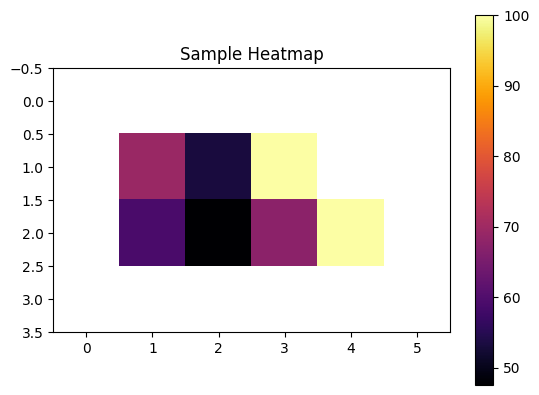

In [24]:
Renderer.create_heatmap(learning_strategy.agent.book_V, cmap='inferno', title='Sample Heatmap')

# <b style="color:#009900">Análise do Monte Carlo em ambiente determinístico</b>

O algoritmo monte carlo utilizado foi colocado em diversas salas com diversos parâmetros diferentes e algumas variações no seu algoritmo. 




##  <b style="color:#22BBBB">Sala 1</b>
A figura abaixo mostra a estrutura da primeira sala usada para avaliação do modelo, a sala mais simples presente.

![Sala 1](figs/sala%201.png)

Aqui é possível visualizar o objetivo na forma de uma moeda e o agente na forma de um alien verde. Além disso é possível ver os caminhos válidos em preto e as paredes em roza. Cada caminho válido aqui garante uma recompensa de -1 ao chegar, enquanto o objetivo garante uma recompensa de 100. Movimentos para cima ou para baixo nesse mapa são sempre em direção a uma parede, o que não move o agente de lugar mas garante uma recompensa de -1. Assim é esperado que esse tipo de atitude seja evitada com o passar do tempo. A política é inicializada de forma aleatória e pode ser verificada na forma de setas azuis, como na figura abaixo:

![Politica inicial da sala 1](figs/politicaInicialSala1.png)

Um primeiro obstáculo foi verificado aqui: Como a política inicial pode iniciar direcionando o agente para um local inválido, o mantendo preso para sempre, é necessário definir um valor máximo de passos para cada episódio. Aqui esse valor foi de 10 passos. Ou seja, o episódio acaba, ou quando o agente atinge o estado terminal, ou após 10 passos.
Após 10 episódios nesse cenário o algoritmo não apresentou uma convergência satisfatória. Porém com 12 episódios a convergência já foi quase absoluta. O número 12 aqui é curioso pois é múltiplo to número de ações disponíveis (4). E nesse cenário há 3 possíveis locais onde o personagem pode surgir e tomar uma ação válida (já que se ele surgir no estado terminal a simulação acaba o impedindo de tomar uma ação). Assim, 12 é um número suficiente para ele testar, com uma boa probabilidade, todas as possibilidades desse ambiente, chegando por fim na política ótima abaixo:

![Politica final da sala 1](figs/politicaFinalSala1.png)


##  <b style="color:#22BBBB">Sala 2</b>
A figura abaixo mostra a estrutura da segunda sala usada para avaliação do modelo, uma das salas mais simples presentes, mas que aumenta levemente o número de caminhos válidos disponíveis e possibilita um movimento vertical limitado.

![Sala 2](figs/sala%202.png)

Diferente da primeira sala, aqui os movimentos são menos limitados e há mais de um caminho ótimo para o agente descobrir. A política inicial aleatória pode ser vista como abaixo:

![Politica inicial da sala 2](figs/politicaInicialSala2.png)

Aqui os 12 episódios não foram suficientes para obter alguma política ótima, e nem era esperado que isso acontece, pois o número de movimentos válidos e caminhos aumentou. Observando A imagem é possível veerificar que há 7 estados não terminais, nos quais 4 possuem apenas 1 movimento ótimo e 3 com 2 movimentos ótimos (direita ou cima). Assim, há um total de 28 opções totais das quais 10 são ótimas. Isso indica que o agente precisa testar no mínimo 18 opções distintas para encontrar uma política ótima. Treinando o modelo com 18 episódios temos (no melhor resultado):

![Politica da sala 2 com 18 episódios](figs/politicaFinalSala2ep18.png)

Aqui podemos ver que o agente errou em apenas 1 estado a política ótima, porém nesse estado ele fica preso. Além disso, esse resultado não reflete o caso médio, que é bem mais desordenado, mostrando que esse caso foi originado por uma política inicial aleatória muito boa e 18 episódios não é o suficiente para treinar o agente de forma adequada. Colocando 36 episódios de treinamento temos uma política mais estável mas não ótima no caso médio, como é possível ver na imagem abaixo:

![Politica da sala 2 com 36 episódios](figs/politicaFinalSala2ep36.png)

Aqui é possível ver que o modelo não está conseguindo convergir para a política ótima, mas está encontrando um caminho válido. Isso pode ser corrigido com mais episódios ou por alteração do valor do reforço final, uma vez que a adição de um único caminho a mais (reforço somado em -1) não tem muito valor quando comparado com o total ganho no final (100).

Após um processo de busca binária no número de episódios, foi possível encontrar o valor de 130 como um valor em que todas as políticas geradas para 20 amostras foram ótimas.

![Politica final da sala 2](figs/politicaFinalSala2.png)

Aqui podemos ver que o valor foi muito superior a 18, evidenciando uma dependência bem mais complexa que a inferida anteriormente, sendo necessário um teste mais preciso.

##  <b style="color:#22BBBB">Sala 4</b>

Aqui a sala é bem maior mas ainda completamente ampla

![Sala 4](figs/sala%202.png)

Nesse cenário, foi necessário a alteração doo limite de passos, uma vez que mesmo com a política ótima, seria impossível que o agente iniciado no canto inferior esquerdo atingisse o estado terminal. Sendo assim ele passou a ser dependente da dimensão do mapa, valendo o número total de quadrados da sala, nesse caso 400. Com isso, após 30000 episódios a política convergiu para uma política próxima da ótima:

![Politica final da sala 4](figs/politicaFinalSala2.png)

Aqui é possível verificar que não foram todos os campos com a política perfeita, mas a adicão de mais episódios toma muito tempo para atingir a política perfeita, logo a partir de agora será dada a política ideal com alguma tolerância em relação a política ótima.

##  <b style="color:#22BBBB">Sala 3</b>

Aqui a sala possui obstáculos no meio do caminho, tornando mais complexa a identificação da política ótima. Além disso o final do caminho (próximo ao objetivo) é muito estreito, o que pode gerar resultados inesperados

![Sala 3](figs/sala%203.png)

Aqui um resultado peculiar ocorreu:

![Politica final da sala 3](figs/politicaFinalSala3ep100.png)

Foi verificado que a política ótima precisa evoluir a partir do objetivo. O que significa que salas grandes com corredores estreitos podem custar muito para o agente aprender a resolver. Com 100 épocas apenas uma região do corredor estava disponível, enquanto que para 200, uma região maior ficou disponível, semelhante ao porcesso de uma busca em largura em um grafo. Assim, foi considerado uma alteração no algoritmo principal. Agora o agente possui uma chance não seguir a política e experimentar uma nova possibilidade. Assim ele não fica tão restrito a posição inicial nem a política aleatória inicial. Dessa forma foram necessários 10000 episódios para convergência da política. Mas uma nova característica foi verificada: Com essa taxa de exploração fixa, o agente esquecia da política aprendida em algumas regiões. Para resolver isso, a taxa de exploração agora decaia com o número de episódios, sendo multiplicada por 0.999 todo final de episódio. Ao final foi produzida a seguinte política:

![Politica final da sala 3](figs/politicaFinalSala3.png)

##  <b style="color:#22BBBB">Salas 5 7 e 8</b>
Mais salas foram adicionadas, para a sala 5:

![Sala 5](figs/sala%205.png)

foram necessários 30000 episódios para atingir a política ideal:

![Politica final da sala 5](figs/politicaFinalSala5.png)

enquanto para a sala 7:

![Sala 7](figs/sala%207.png)

O valor de 30000 levou muito mais tempo para finalizar, gerando a política:

![Politica final da sala 7](figs/politicaFinalSala7ep30000.png)

Aqui podemos ver que apenas o corredor inicial foi analisado, mas o tempo de treinamento foi de 3 minutos, o que torna o processo muito custoso.

Para a última sala, a 8 temos:

![Sala 8](figs/sala%208.png)

O treinamento com 1000 épocas custou 45 segundos, indicando um custo computacional elevado para computar todos episódios. Assim é possível verificar que o Monte Carlo possui muitas dificuldades quando o ambiente possui muitos estados diferentes.

![Politica final da sala 7](figs/politicaFinalSala8.png)

Com essas 1000 épocas o agente n foi capaz de aprender nem mesmo o estado ao lado do terminal, logo nada foi aprendido nesse ambiente com tantos cenários.



# <b style="color:#009900">Análise do Monte Carlo em ambiente estocástico</b>
A estocásticidade do ambiente é dado por um valor racional de 0 a 1 e simboliza a chance de determinada ação trocar para uma outra ação aleatória. Para s = 0.33 significa que há 33% de chance da ação escolhida (ir para a direita por exemplo), trocar para outra ação aleatória (ir para cima por exemplo)

##  <b style="color:#22BBBB">Sala 1</b>

Para uma estocasticidade de 0.1, nenhuma alteração significativa foi percebida, o ambiente se comporta da mesma forma, levando o mesmo número de episódios para convergir ara a política ótima. Com o aumento do número de épocas, nenhuma mudança na política foi verificada.

Para s = 0.5, em metade dos casos a política não convergiu para a ótica, assumindo valores como:

![Politica final da sala 1 estocástica](figs/politicaFinalSala1Esto.png)

Para corrigir esse erro, a quantidade de episódios aumentou para 100 (que ainda apresentou erro), e posteriormente para 1000, ficando completamente ótimo.

Para s = 0.75, 1000 episódios não foi o suficiente, enquanto 2000 parece melhorar ao limite, mas não atingindo a política ótima. Nesse ambiente, se em algum momento a política atinge um valor para uma direção inválida, esse valor não é alterado, uma vez que a chance de exploração somada a estocasticidade do ambiente fazem com que os movimentos sejam quase totalmente independentes da política, dificultando o aprendizado.

Como esperado, para s = 1, nenhuma política é derivada do aprendizado, uma vez que não importa a decisão do agente, a ação será completamente aleatória.

##  <b style="color:#22BBBB">Sala 2</b>

A sala 2 foi avaliada com a estocasticidade de 0.1, o que não gerou nenhuma mudança significativa no treinamento do agente, 0.5, precisando de 1000 episódios para obter uma política aceitável (com um estado erro no máximo), e 0.75 foi necessário 2000 episódios para convergir.

Na sala 3 e estocasticidade 0.1, o modelo foi treinado com 10000 episódios gerando a política abaixo

![Politica final da sala 3 estocástica](figs/politicaFinalSala3sto01e1000.png)

Aqui podemos ver que mesmo com uma estocasticidade baixa, o agente não consegue aprender a política ideal, possivelmente por que para um caminho maior, esse valor se torna bem mais relevante. Para atingir uma qualidade aceitável da política, foram necessários 160000 episódios.
Para estocasticidade de 0.5, o modelo deixou de convergir, encontrando políticas sem sentido mesmo para 320000 episódios

![Politica final da sala 3 estocástica](figs/politicaFinalSala3sto05ep320000.png)

Para a sala 4 



# <b style="color:#009900">Metricas</b>

Para as métricas abaixo, foi calculado para treinos e testes com a seed 42.

##  <b style="color:#22BBBB">Monte carlo sem aproximador e em ambiente determinístico, 1000 episódios</b>

|sala             |tempo |taxa |recompensa|passos |
|-----------------|------|-----|----------|-------|
|1  |0.04  |100.0|98.0      |2.0    |
|2  |0.046 |100.0|97.71     |2.29   |
|3  |0.264 |22.22|-57.06    |78.5   |
|3.1|0.111 |100.0|92.35     |7.65   |
|3.2|0.076 |100.0|95.08     |4.92   |
|4  |0.632 |52.94|-143.03   |195.5  |
|5  |1.142 |19.05|-306.1    |324.33 |
|6  |8.198 |78.69|-472.26   |550.75 |
|7  |12.497|8.51 |-2279.85  |2287.45|
|8  |17.299|0.0  |-3001.0   |3000.0 |
|9  |1.45  |25.64|-283.72   |298.64 |
|10 |0.27  |47.83|-24.83    |72.13  |
|11 |0.253 |63.16|15.79     |47.0   |
|12 |0.249 |82.86|54.86     |27.83  |


##  <b style="color:#22BBBB">Monte carlo sem aproximador e em ambiente determinístico, 10000 episódios</b>

|sala             |tempo  |taxa |recompensa|passos |
|-----------------|-------|-----|----------|-------|
|1  |0.336  |100.0|98.0      |2.0    |
|2  |0.433  |100.0|97.71     |2.29   |
|3  |2.338  |38.89|-25.78    |64.06  |
|3.1|0.823  |100.0|92.7      |7.3    |
|3.2|0.521  |100.0|95.42     |4.58   |
|4  |1.792  |100.0|87.94     |12.06  |
|5  |9.218  |35.71|-224.19   |259.26 |
|6  |70.496 |96.08|-23.51    |119.5  |
|7  |82.09  |12.77|-2169.4   |2181.3 |
|8  |102.726|11.11|-2656.81  |2667.03|
|9  |11.838 |43.59|-188.26   |228.97 |
|10 |2.162  |86.96|62.26     |24.57  |
|11 |1.22   |100.0|92.79     |7.21   |
|12 |1.445  |100.0|91.26     |8.74   |

##  <b style="color:#22BBBB">Monte carlo sem aproximador e em ambiente determinístico, 100000 episódios</b>

|sala             |tempo   |taxa |recompensa|passos |
|-----------------|--------|-----|----------|-------|
|1  |5.119   |100.0|98.0      |2.0    |
|2  |4.104   |100.0|97.71     |2.29   |
|3  |20.927  |44.44|-15.61    |59.5   |
|3.1|8.976   |100.0|92.7      |7.3    |
|3.2|6.324   |100.0|95.42     |4.58   |
|4  |11.079  |100.0|88.41     |11.59  |
|5  |39.406  |83.33|7.26      |75.9   |
|6  |711.838 |98.69|43.81     |54.86  |
|7  |912.406 |17.02|-2059.04  |2075.23|
|8  |1366.857|36.11|-1883.43  |1918.9 |
|9  |74.364  |66.67|-76.97    |140.31 |
|10 |21.304  |100.0|90.83     |9.17   |
|11 |14.014  |100.0|92.79     |7.21   |
|12 |15.336  |100.0|91.26     |8.74   |

Assim podemos verificar o ganho de eficiência do algoritmo com o aumento do número de episódios mas como o custo computacional aumenta muito, 1e4 apresenta um bom custo benefício e será mantido para os outros testes.

##  <b style="color:#22BBBB">Monte carlo sem aproximador e em ambiente estocástico, 0.1 , 10000 episódios</b>


|sala             |tempo   |taxa |recompensa|passos |
|-----------------|--------|-----|----------|-------|
|salas/sala1.txt  |0.439   |100.0|98.0      |2.0    |
|salas/sala2.txt  |0.431   |100.0|97.57     |2.43   |
|salas/sala3.txt  |2.296   |44.44|-19.44    |63.33  |
|salas/sala3.1.txt|0.778   |100.0|92.26     |7.74   |
|salas/sala3.2.txt|0.565   |100.0|94.29     |5.71   |
|salas/sala4.txt  |1.995   |100.0|84.44     |15.56  |
|salas/sala5.txt  |7.895   |73.81|-100.76   |174.31 |
|salas/sala6.txt  |60.119  |56.52|-1221.26  |1277.35|
|salas/sala7.txt  |85.739  |17.02|-2085.98  |2102.17|
|salas/sala8.txt  |94.089  |33.33|-2174.92  |2207.58|
|salas/sala9.txt  |7.157   |82.05|-50.38    |122.51 |
|salas/sala10.txt |1.953   |82.61|12.83     |43.52  |
|salas/sala11.txt |1.776   |100.0|82.32     |7.16   |
|salas/sala12.txt |1.266   |100.0|87.91     |12.09  |

##  <b style="color:#22BBBB">Monte carlo sem aproximador e em ambiente estocástico, 0.5 , 10000 episódios</b>

|sala             |tempo   |taxa |recompensa|passos |
|-----------------|--------|-----|----------|-------|
|salas/sala1.txt  |0.531   |100.0|92.0      |8.0    |
|salas/sala2.txt  |0.731   |100.0|94.29     |5.71   |
|salas/sala3.txt  |3.615   |22.22|-61.61    |83.06  |
|salas/sala3.1.txt|4.015   |100.0|80.61     |19.39  |
|salas/sala3.2.txt|1.061   |100.0|91.25     |8.75   |
|salas/sala4.txt  |3.456   |100.0|62.26     |37.74  |
|salas/sala5.txt  |7.088   |83.33|-79.26    |162.43 |
|salas/sala6.txt  |56.169  |66.52|-1017.18  |1083.37|
|salas/sala7.txt  |109.078 |21.28|-2051.02  |2071.51|
|salas/sala8.txt  |104.403 |40.28|-1856.5   |1896.18|
|salas/sala9.txt  |5.61    |87.18|-62.36    |115.51 |
|salas/sala10.txt |3.261   |52.17|-38.48    |69.13  |
|salas/sala11.txt |3.617   |63.16|-11.32    |53.05  |
|salas/sala12.txt |2.02    |97.14|57.14     |28.54  |


##  <b style="color:#22BBBB">Monte carlo sem aproximador e em ambiente estocástico, 0.7 , 10000 episódios</b>

|sala             |tempo   |taxa |recompensa|passos |
|-----------------|--------|-----|----------|-------|
|salas/sala1.txt  |0.563   |100.0|95.33     |4.67   |
|salas/sala2.txt  |3.551   |100.0|90.57     |9.43   |
|salas/sala3.txt  |3.477   |22.22|-60.33    |81.78  |
|salas/sala3.1.txt|2.992   |78.26|30.04     |48.0   |
|salas/sala3.2.txt|1.649   |100.0|79.54     |20.46  |
|salas/sala4.txt  |7.842   |94.12|-30.68    |124.74 |
|salas/sala5.txt  |11.378  |57.14|-168.4    |225.12 |
|salas/sala6.txt  |105.498 |23.48|-1982.65  |2005.37|
|salas/sala7.txt  |116.68  |17.02|-2150.62  |2166.81|
|salas/sala8.txt  |112.991 |54.17|-1585.78  |1639.49|
|salas/sala9.txt  |8.319   |64.1 |-188.23   |211.92 |
|salas/sala10.txt |2.864   |56.52|-56.26    |61.91  |
|salas/sala11.txt |3.286   |73.68|-28.68    |38.95  |
|salas/sala12.txt |3.196   |65.71|-56.49    |64.71  |



